## 포트홀 탐지 모델(모델 학습 후 검출)

### YOLOv5 모델 다운로드

In [ ]:
# yolov5 모델 다운로드
!git clone https://github.com/ultralytics/yolov5.git 

Cloning into 'yolov5'...
remote: Enumerating objects: 12178, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 12178 (delta 15), reused 15 (delta 3), pack-reused 12140
Receiving objects: 100% (12178/12178), 12.56 MiB | 31.45 MiB/s, done.
Resolving deltas: 100% (8375/8375), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

기본 환경 세팅

In [ ]:
# yolov5 폴더 이동
%cd yolov5

# YOLOv5 개발환경과 동일한 버젼을 다운로드 받아 설치
!pip install -qr requirements.txt

/content/yolov5
     |████████████████████████████████| 1.6 MB 7.9 MB/s 


### 데이터셋 다운로드

* 포트홀 데이터셋: https://public.roboflow.com/object-detection/pothole

In [ ]:
# 데이터 폴더 생성
%mkdir /content/yolov5/pothole

In [ ]:
# 데이터 폴더 이동
%cd /content/yolov5/pothole

/content/yolov5/pothole


- 데이터셋 다운로드: roboflow.com 사이트 접속 => pothole 이미지 다운로드 클릭
 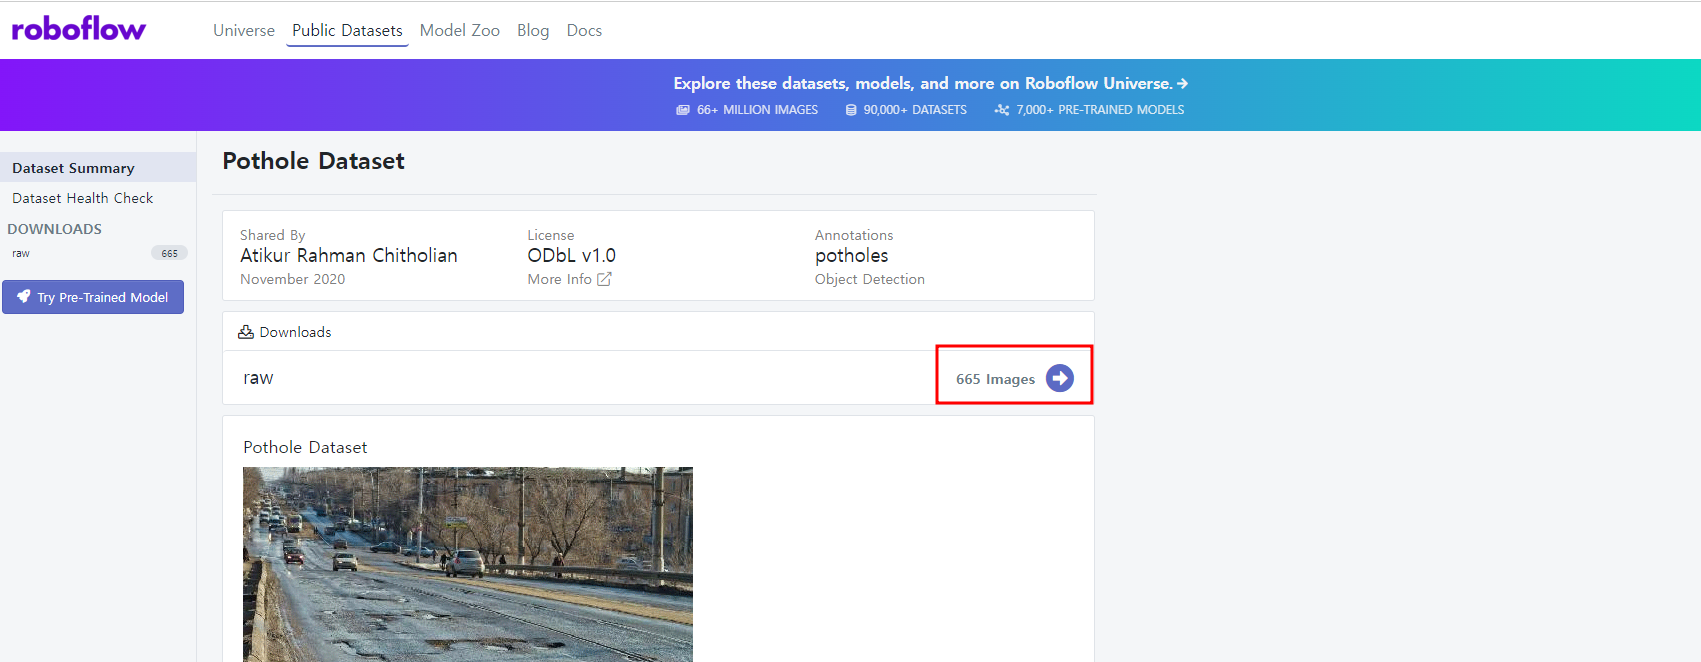

- YOLO v5 PyTorch 선택 => show download code 선택 => [Continue] 클릭
 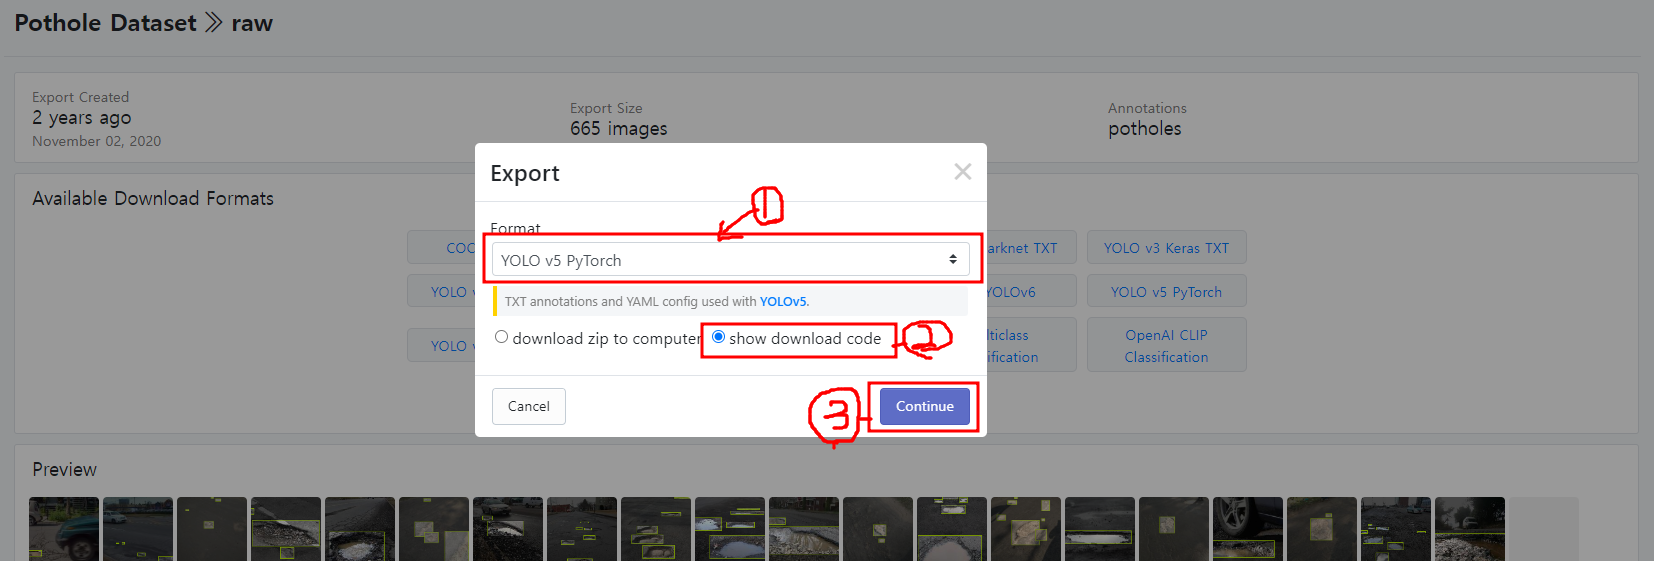

- 다운로드 및 압축 해제 코들 복사
 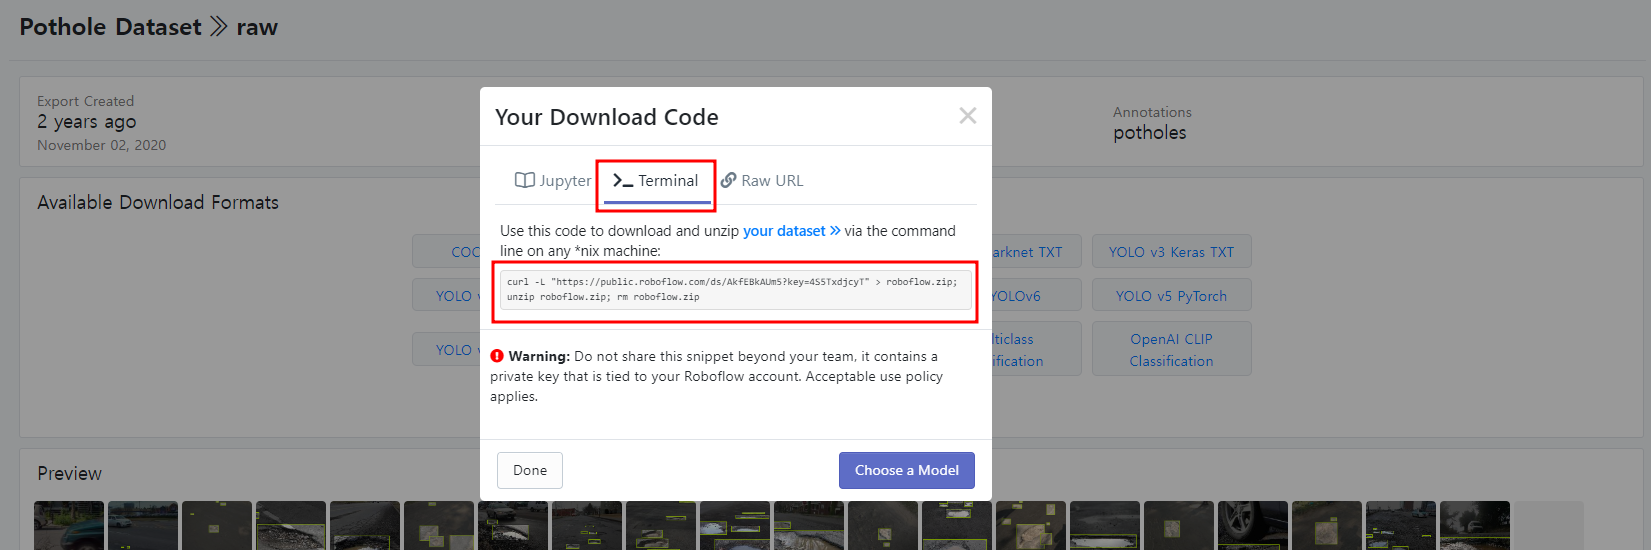

In [ ]:
# 복사한 코드 실행(다운로드 및 압축 해제)
!curl -L "https://public.roboflow.com/ds/AkfEBkAUm5?key=4S5TxdjcyT" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   901  100   901    0     0   3478      0 --:--:-- --:--:-- --:--:--  3478
100 46.0M  100 46.0M    0     0  47.7M      0 --:--:-- --:--:-- --:--:-- 92.0M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/img-105_jpg.rf.3fe9dff3d1631e79ecb480ff403bcb86.jpg  
 extracting: test/images/img-107_jpg.rf.2e40485785f6e5e2efec404301b235c2.jpg  
 extracting: test/images/img-146_jpg.rf.61be25b3053a51f622a244980545df2b.jpg  
 extracting: test/images/img-161_jpg.rf.211541e7178a4a93ec0680f26b905427.jpg  
 extracting: test/images/img-168_jpg.rf.af3590e07b06b43e91fa53990ff94af3.jpg  
 extracting: test/images/img-179_jpg.rf.8632eb0d9b75fefe144829e67b75015a.jpg  
 extracting: test/images/img

- 참고로 YOLOv5 공식계정의 코드는 txt 포맷의 레이블링 데이터를 사용한다. 
- 이 파일은 이미지에서 검출된 object에 대한 클래스와 bounding box 정보를 포함하고 있다. 
- 검출 객체정보 배치는 [class, x_center, y_center, width, height] 형태로 되어있다. 
- bounding box 정보는 이미지 사이즈에 의해 정규화 되어있다. 따라서 0~1 범위의 값을 가진다.

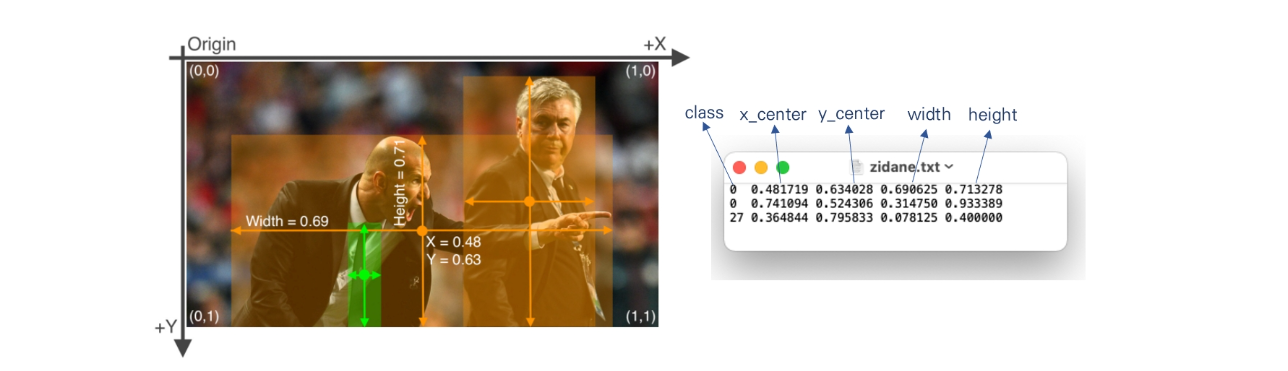

### 포트홀 데이터 목록 생성하기

In [ ]:
import torch
from IPython.display import Image, clear_output

In [ ]:
%ls

data.yaml  README.dataset.txt  README.roboflow.txt  test/  train/  valid/


In [ ]:
# glob 모듈을 이용한 train, test, valid 데이터 목록 생성
import glob

train_img_list=glob.glob('/content/yolov5/pothole/train/images/*.jpg')
test_img_list=glob.glob('/content/yolov5/pothole/test/images/*.jpg')
valid_img_list=glob.glob('/content/yolov5/pothole/valid/images/*.jpg')

print(len(train_img_list), len(test_img_list), len(valid_img_list))

465 67 133


In [ ]:
# train, test, valid 이미지 데이터 정보 txt 파일로 생성
with open('/content/yolov5/pothole/train/train.txt', 'w') as f:
    f.write('\n'.join(train_img_list) + '\n')

with open('/content/yolov5/pothole/test/test.txt', 'w') as f:
    f.write('\n'.join(test_img_list) + '\n')

with open('/content/yolov5/pothole/valid/valid.txt', 'w') as f:
    f.write('\n'.join(valid_img_list) + '\n')

### yaml 파일 생성하기
- register_line_cell_magic 모듈 사용
- IPython에서 입력된 내용을 텍스트처럼 계속 사용 가응

In [ ]:
import yaml 

# IPython에서 입력된 내용을 텍스트처럼 계속 사용하기 위한 register_line_cell_magic 정의
from IPython.core.magic import register_line_cell_magic

# register_line_cell_magic을 이용해 IPython에서 바로 사용할 수 있게 정의
# writetimplate를 쉽게 사용할 수 있음
@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
# data.yaml 내용 확인하기
%cat '/content/yolov5/pothole/data.yaml'

train: ../train/images
val: ../valid/images

nc: 1
names: ['pothole']

In [ ]:
# writetemplate 함수를 이용해 train/test/val 데이터 폴더 수정하기
%%writetemplate /content/yolov5/pothole/data.yaml

train: ./pothole/train/images
test: ./pothole/test/images
val: ./pothole/valid/images

nc: 1
names: ['pothole']

In [ ]:
# 수정 내용 확인하기
%cat '/content/yolov5/pothole/data.yaml'


train: ./pothole/train/images
test: ./pothole/test/images
val: ./pothole/valid/images

nc: 1
names: ['pothole']


### 모델 구성하기

- 학습을 시키기 전 YOLOv5의 모델 중 어떤 것을 사용할지 결정한다.
- 크기가 크면 클수록 복잡해지고 정확성이 높아지는 대신, 시간이 오래걸리고 GPU의 메모리를 많이 차지한다.

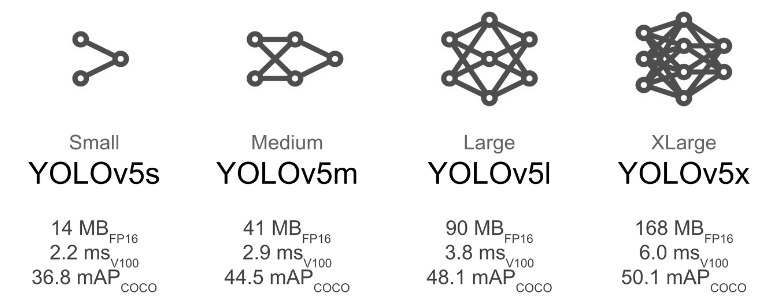

In [ ]:
# 기본 모델 내용 확인하기
!cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

%%writetemplate을 이용한 nc 값 변경(학습 데이터 클래스 개수와 동일하게 수정)<br>
위 내용 복사해서 붙여넣기 후 nc: 1 로 변경

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# Parameters
nc: 1  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
# 변경 내용 확인
!cat /content/yolov5/models/custom_yolov5s.yaml


# Parameters
nc: 1  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, Fa

### 모델 학습(Training)
- 모델 학습 순서
  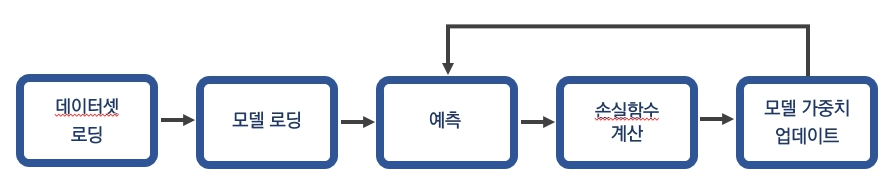

In [ ]:
%pwd

'/content/yolov5/pothole'

- YOLOv5 디렉토리로 이동한 뒤, train.py 파일을 이용해 학습을 시켜주면 된다.

In [ ]:
# yolov5로 폴더 이동
%cd /content/yolov5

/content/yolov5


- 위의 그림과 같은 일련의 과정은 train.py 파일 실행을 통해 가능하다. 
- 인자로 학습 데이터 경로와 epoch 수를 입력하고 학습을 진행(아래 인자 참조)
    * `img`: 입력 이미지 크기 정의
    * `batch`: 배치 크기 결정
    * `epochs`: 학습 기간 개수 정의
    * `data`: yaml 파일 경로
    * `cfg`: 모델 구성 지정
    * `weights`: 가중치에 대한 경로 지정
    * `name`: 결과 이름
    * `nosave`: 최종 체크포인트만 저장
    * `cache`: 빠른 학습을 위한 이미지 캐시

In [ ]:
# 데이터 학습하기
!python train.py --img 640 --batch 32 --epochs 100 --data ./pothole/data.yaml --cfg ./models/custom_yolov5s.yaml --weight '' --name pothole_results --cache

train: weights=, cfg=./models/custom_yolov5s.yaml, data=./pothole/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=pothole_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-90-g63ecce6 Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, 

yolov5/runs/train/모델이름 폴더 안을 살펴보면,<br>
train 및 test batch마다의 실제 정답(레이블링)과 예측된 학습결과를 미리볼 수 있다.

In [ ]:
# train 결과 파일 확인
!ls /content/yolov5/runs/train/pothole_results/

confusion_matrix.png				   results.png
events.out.tfevents.1662284705.e0632beb0de9.210.0  train_batch0.jpg
F1_curve.png					   train_batch1.jpg
hyp.yaml					   train_batch2.jpg
labels_correlogram.jpg				   val_batch0_labels.jpg
labels.jpg					   val_batch0_pred.jpg
opt.yaml					   val_batch1_labels.jpg
P_curve.png					   val_batch1_pred.jpg
PR_curve.png					   val_batch2_labels.jpg
R_curve.png					   val_batch2_pred.jpg
results.csv					   weights


train 데이터 확인

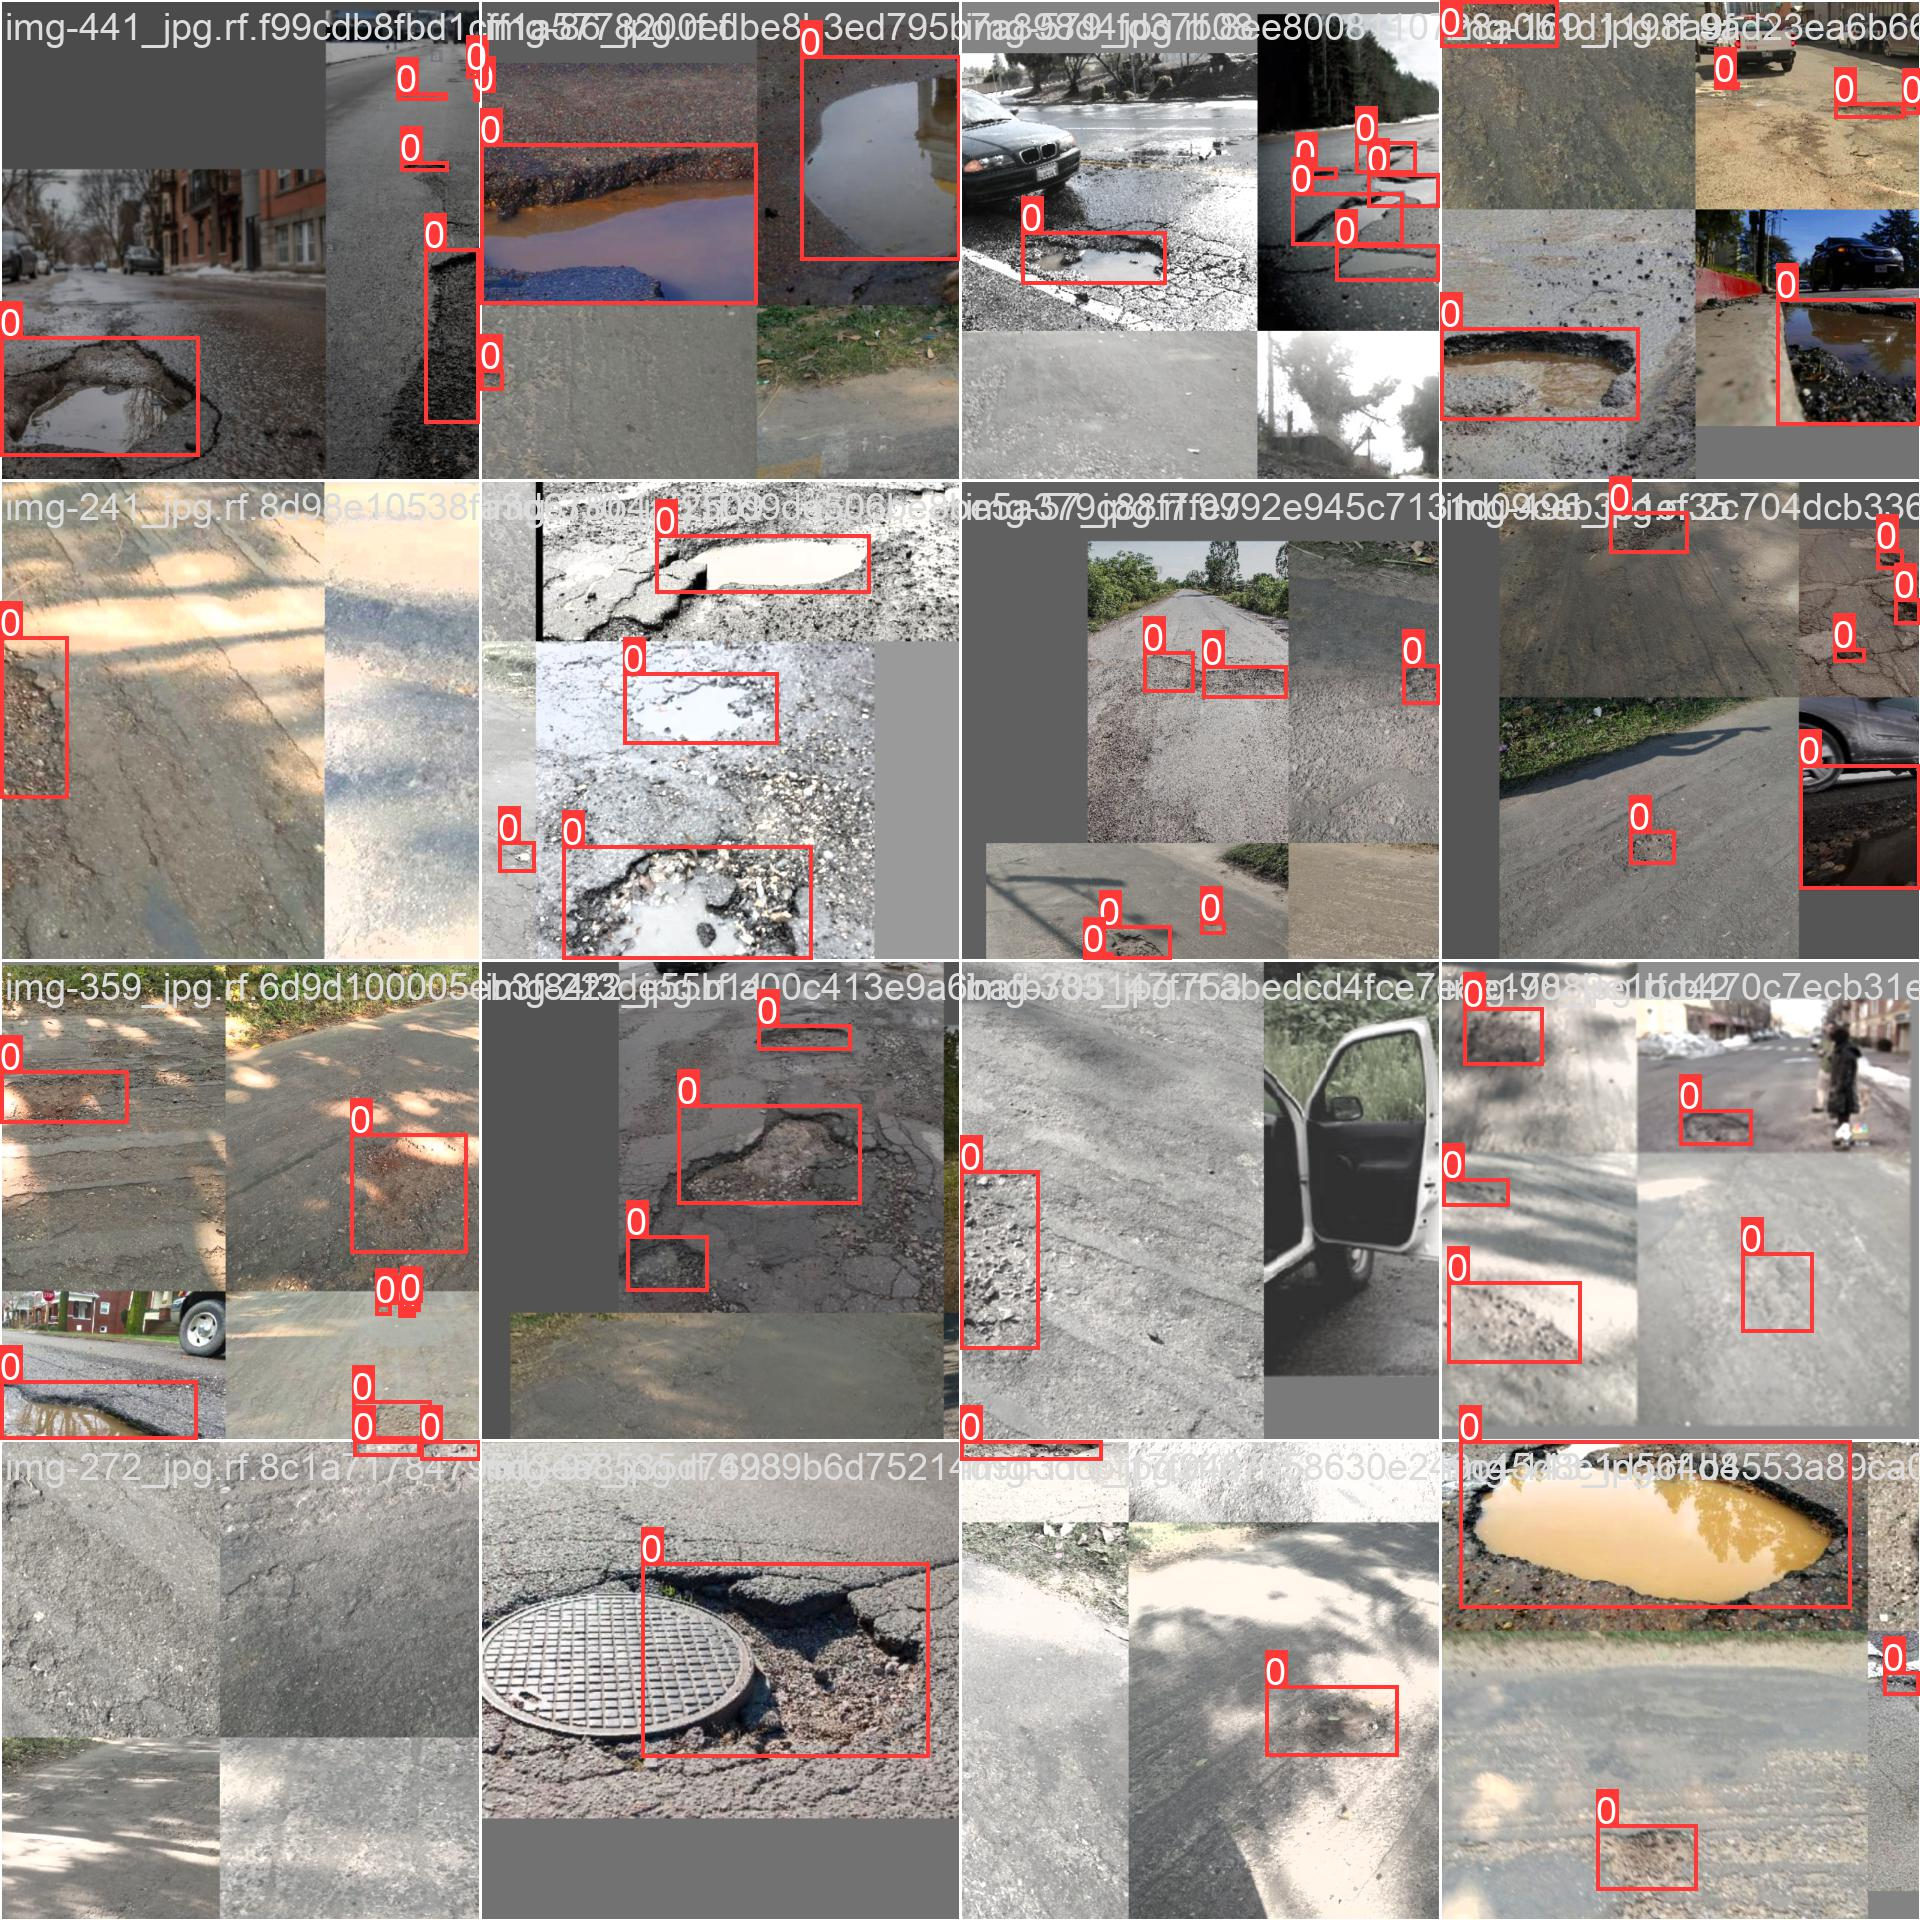

In [ ]:
Image(filename='/content/yolov5/runs/train/pothole_results/train_batch0.jpg', width=800)

검증하는 Validation도 확인

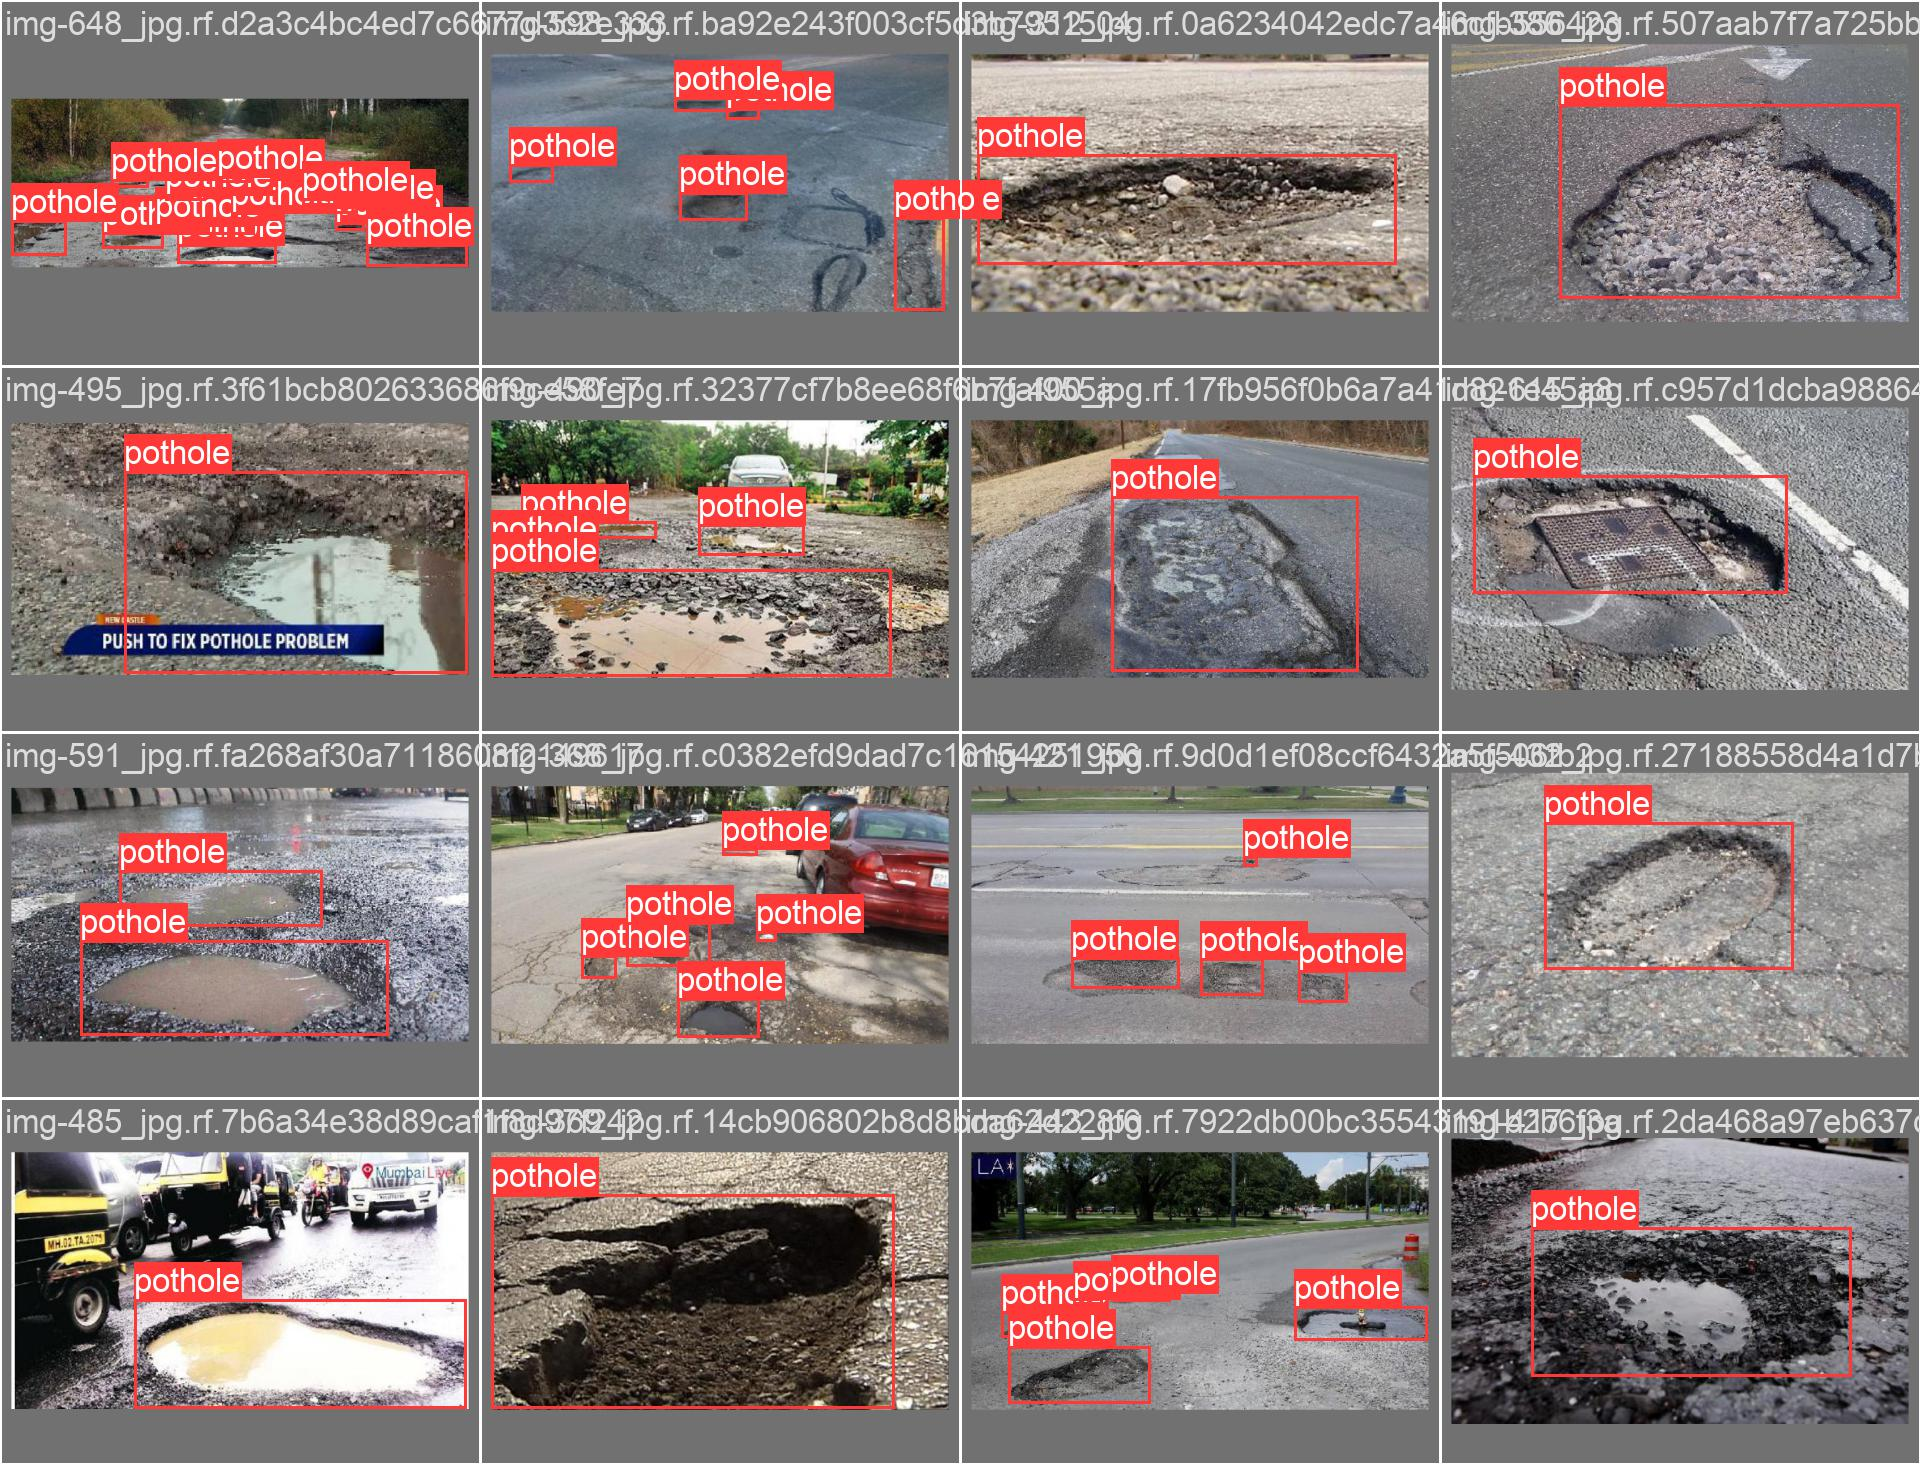

In [ ]:
Image(filename='/content/yolov5/runs/train/pothole_results/val_batch0_labels.jpg', width=800)

여러 시각화 그래프를 통해 loss , mAP 등의 결과를 한 눈에 나타내는 지표도 확인가능(result.png)

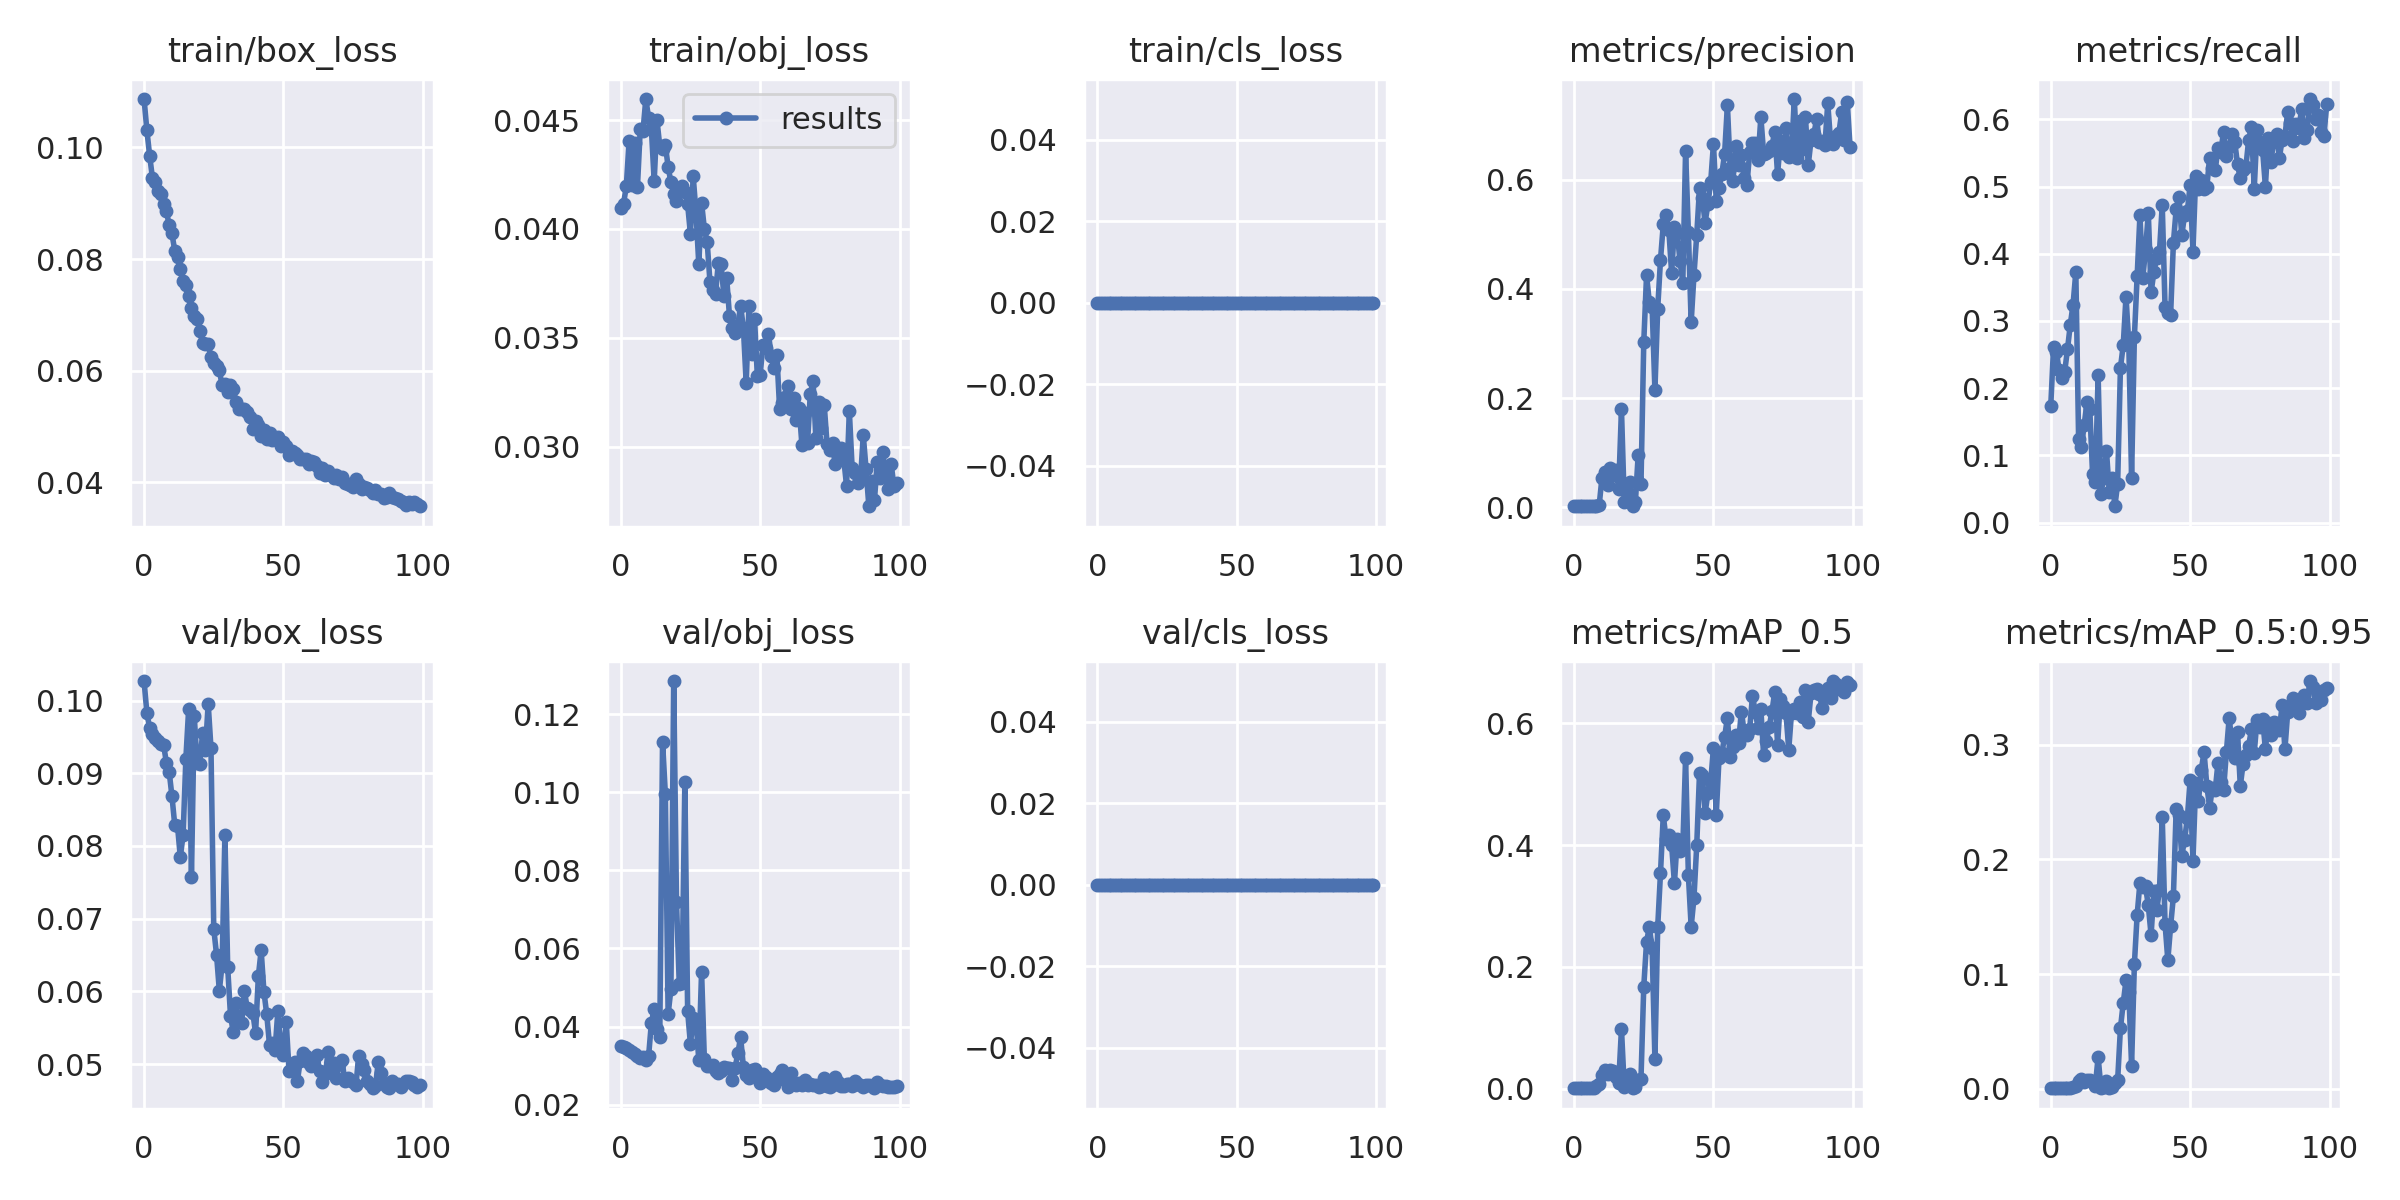

In [ ]:
Image(filename='/content/yolov5/runs/train/pothole_results/results.png', width=800)

In [ ]:
# tensorboard을 이용한 진행 상황 확인
%load_ext tensorboard
%tensorboard --logdir /content/yolov5/runs/

### 검증(Validation)
- bast.pt를 이용한 모델 검증

In [ ]:
!python val.py --weights runs/train/pothole_results/weights/best.pt --data ./pothole/data.yaml --img 640 --iou 0.65 --half

val: data=./pothole/data.yaml, weights=['runs/train/pothole_results/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.65, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=True, dnn=False
YOLOv5 🚀 v6.2-90-g63ecce6 Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
custom_YOLOv5s summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning '/content/yolov5/pothole/valid/labels.cache' images and labels... 133 found, 0 missing, 0 empty, 0 corrupt: 100% 133/133 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R     mAP@.5 mAP@.5:.95: 100% 5/5 [00:04<00:00,  1.11it/s]
                   all        133        330      0.653      0.636      0.665      0.358
Speed: 0.2ms pre-process, 3.7ms inference, 2.5ms NMS per image at shape (32, 

In [ ]:
!python val.py --weights runs/train/pothole_results/weights/best.pt --data ./pothole/data.yaml --img 640 --task test

val: data=./pothole/data.yaml, weights=['runs/train/pothole_results/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.2-90-g63ecce6 Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
custom_YOLOv5s summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning '/content/yolov5/pothole/test/labels' images and labels...67 found, 0 missing, 0 empty, 0 corrupt: 100% 67/67 [00:00<00:00, 474.25it/s]
test: New cache created: /content/yolov5/pothole/test/labels.cache
                 Class     Images  Instances          P          R     mAP@.5 mAP@.5:.95: 100% 3/3 [00:02<00:00,  1.19it/s]
                   all         67        154      0.675      0.591      0.677      0.358
Speed: 0.2

### 학습된 모델 사용해보기: 추론(Inference)
- 사용자 이미지를 이용한 포트홀 감지
-  yolov5 안에 있는 detect.py를 이용하면 다른 사진들을 가지고도 모델을 실행
- 사진 뿐 아니라 동영상, 웹캠, 유튜브 영상도 이용할 수 있다.

In [ ]:
!ls /content/yolov5/runs/train/pothole_results/weights

best.pt  last.pt


In [ ]:
# yolov5 안에 있는 detect.py를 이용하면 다른 사진들을 가지고도 모델을 실행
!python detect.py --weights runs/train/pothole_results/weights/best.pt --img 640 --conf 0.4 --source ./pothole/test/images

detect: weights=['runs/train/pothole_results/weights/best.pt'], source=./pothole/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.2-90-g63ecce6 Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
custom_YOLOv5s summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/67 /content/yolov5/pothole/test/images/img-105_jpg.rf.3fe9dff3d1631e79ecb480ff403bcb86.jpg: 640x640 1 pothole, 6.3ms
image 2/67 /content/yolov5/pothole/test/images/img-107_jpg.rf.2e40485785f6e5e2efec404301b235c2.jpg: 640x640 1 pothole, 6.6ms
image 3/67 /content/yolov5/pothole/test/images/img-146_jpg.rf.61be25b3053a51f

추론 결과 확인: 추론 이미지들 중 램덤으로 하나 출력

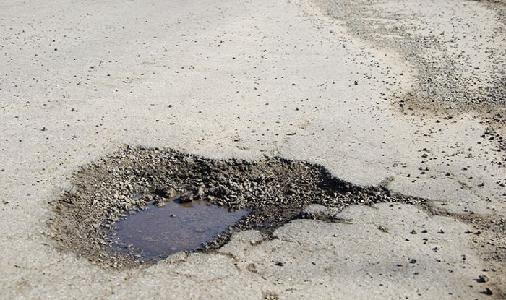

In [ ]:
import glob
import random

image_name=  random.choice(glob.glob('/content/yolov5/runs/detect/exp/*.jpg'))
Image(filename=image_name)

### 모델 내보내기
- bast.pt 모델 코랩으로 내보내기

In [ ]:
# 코랩 드라이브 연결

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# pothole 폴더 생성
%mkdir /content/drive/MyDrive/deu/model/pothole

In [ ]:
# 폴더로 bast.pt 모델 
%cp /content/yolov5/runs/train/pothole_results/weights/best.pt /content/drive/MyDrive/deu/model/pothole